In [19]:
import pandas as pd
import os
import spacy
nlp = spacy.load('en')
# Add neural coref to SpaCy's pipe
import neuralcoref
neuralcoref.add_to_pipe(nlp)
import networkx as nx
import operator
import nltk
from nltk.stem import WordNetLemmatizer
import datetime
import time
import ast
import string
import pygal
#import cairosvg
import codecs
import csv
import string
import multidict
from pygal.style import Style


In [20]:
import spacy
#spacy.util.set_data_path("D:\Anaconda\lib\site-packages\spacy")
spacy.load('en')

In [6]:
#!python -m spacy download en

In [8]:
#spacy.util.set_data_path("D:\Anaconda\lib\site-packages\spacy")
#spacy.load('en')

In [21]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Reen\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Reen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [23]:
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_watson.natural_language_understanding_v1 import Features, EntitiesOptions, KeywordsOptions,SemanticRolesOptions,RelationsOptions

In [13]:
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [15]:
import multidict as multidict
import os
import re
from PIL import Image
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [16]:
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

In [24]:
natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2018-11-16',
    iam_apikey='JxvnihDojci02S25uZkusc79w8tkmJxEuohB4ooGBMdz',
    url='https://gateway-lon.watsonplatform.net/natural-language-understanding/api'
)

In [94]:
def compute_all_features(text):
    response = natural_language_understanding.analyze(
                    text=text,
                    features=Features(entities=EntitiesOptions(),
                                      keywords=KeywordsOptions(sentiment = True,emotion = True),
                                      semantic_roles=SemanticRolesOptions(keywords=True,entities=True),
                                      relations=RelationsOptions()),
                    language='en').get_result()
    key_sent = {}
    for words in response['keywords']:
        key_sent[words['text']] = words['sentiment']['score']
    key_emotion = {}
    for words in response['keywords']:
        key_emotion[words['text']] = words['emotion']
    keylist_rel = {}
    for key in response['keywords']:
        key_ent = key['text']
        rel = key['relevance']
        keylist_rel[key_ent] = rel
    entities_rel = {}
    G = nx.Graph()
    sub = None
    obj = None
    
    for role in response["semantic_roles"]:
        subject = role['subject']['text'].lower()

        max_rel = 0
        max_ent = []
        if('keywords' in role['subject'].keys()):
            for ent in role['subject']['keywords']:
                ent_text = ent['text'].lower()

                for dict_key in keylist_rel.keys():
                    if(ent_text in dict_key.lower()):
                            ent_rel =  keylist_rel[dict_key]

                            if(ent_rel>max_rel):
                                max_rel = ent_rel 
                                max_ent = ent
                if(max_rel!=0 and max_ent):
                    sub = max_ent['text']
                    G.add_node(sub)

        verb = role['action']['verb']['text'].lower()

        max_rel = 0
        max_ent = []
        if('object' in role.keys()):
            object = role['object']['text'].lower()
            if('keywords' in role['object'].keys()):
                for obj in role['object']['keywords']:
                    obj_text = obj['text'].lower()

                    for dict_key in keylist_rel.keys():
                        if(obj_text in dict_key.lower()):
                            obj_rel =  keylist_rel[dict_key]

                            if(obj_rel>max_rel):
                                max_rel = obj_rel 
                                max_ent = obj
                    if(max_rel!=0 and max_ent):
                        obj = max_ent['text']
                        G.add_node(obj)
                        if(sub and obj and sub!=obj):
                            G.add_edge(sub,obj)
    return nx.closeness_centrality(G), key_sent, key_emotion

In [95]:
def sort_dict(my_dict):
    return sorted(my_dict.items(), key=operator.itemgetter(1),reverse=True)

In [96]:
def convert_to_list(my_dict):
    my_list = []
    for i in range(len(my_dict)):
        my_list.append(list(my_dict[i]))
    return my_list

In [97]:
def get_match(mylist,list):
    maxval = 0
    r_ent_rel = [None,None]
    for tup in list:
        count = 0
        otherlist = tup[0].split(" ")
        for myword in mylist:
            for otherword in otherlist:
                if lemmatizer.lemmatize(myword.lower()) == lemmatizer.lemmatize(otherword.lower()):
                    count+=1
        if count > maxval:
            maxval = count
            r_ent_rel = [tup[0],tup[1]]
    return r_ent_rel

In [98]:
def does_contain(str1,str2):
    count = 0
    str1 = str1.split(" ")
    str2 = str2.split(" ")
    for word1 in str1:
        for word2 in str2:
            if(word1.lower() == word2.lower()):
                count+=1
    return count

In [99]:
def get_sent(str,dict):
    if str in dict :
        return dict[str]
    maxval = 0
    rval = None
    str = str.split(" ")
    for keys in dict:
        count = 0
        for mywords in str:
            for otherwords in keys.split(" "):
                if(mywords.lower() == otherwords.lower()):
                    count+=1
        if count > maxval:
            maxval = count
            rval = dict[keys]
    return rval

In [100]:
def common_computation(trst_cent,os1_cent,os2_cent):
    
    shift_list = []
    trst_os1 = []
    trst_os2 = []
    for trst_ent_rel in trst_cent:
        trst_ent = trst_ent_rel[0].split(" ")
        os1_ent_rel = get_match(trst_ent,os1_cent)
        os2_ent_rel = get_match(trst_ent,os2_cent)
        if(os1_ent_rel[0] is None and os2_ent_rel[0] is None):
            trst_os1.append(trst_ent_rel)
            trst_os2.append(trst_ent_rel)
        elif(os1_ent_rel[0] is None):
            trst_os1.append(trst_ent_rel)
        elif(os2_ent_rel[0] is None):
            trst_os2.append(trst_ent_rel)
        else:
            shift_list.append([trst_ent_rel,os1_ent_rel,os2_ent_rel])
            
    
    os1_trst = []
    os1_os2 = []
    for os1_ent_rel in os1_cent:
        os1_ent = os1_ent_rel[0].split(" ")
        os2_ent_rel = get_match(os1_ent,os2_cent)
        trst_ent_rel = get_match(os1_ent,trst_cent)
        if(os2_ent_rel[0] is None and trst_ent_rel[0] is None):
            os1_trst.append(os1_ent_rel)
            os1_os2.append(os1_ent_rel)
        elif(os2_ent_rel[0] is None):
            os1_os2.append(os1_ent_rel)
        elif(trst_ent_rel[0] is None):
            os1_trst.append(os1_ent_rel)   

    os2_os1 = []
    os2_trst = []
    for os2_ent_rel in os2_cent:
        os2_ent = os2_ent_rel[0].split(" ")
        trst_ent_rel = get_match(os2_ent,trst_cent)
        os1_ent_rel = get_match(os2_ent,os1_cent)
        if(trst_ent_rel[0] is None and os1_ent_rel[0] is None):
            os2_os1.append(os2_ent_rel)
            os2_trst.append(os2_ent_rel)
        elif(trst_ent_rel[0] is None):
            os2_trst.append(os2_ent_rel)
        elif(os1_ent_rel[0] is None):
            os2_os1.append(os2_ent_rel)


    for i in range(len(shift_list)):
        for j in range(i + 1,len(shift_list)):
            if(does_contain(shift_list[i][0][0],shift_list[j][0][0])):
                shift_list[i][0][1] += shift_list[j][0][1]
                shift_list[i][1][1] += shift_list[j][1][1]
                shift_list[i][2][1] += shift_list[j][2][1]
                shift_list[j][0][1] = 0
                shift_list[j][1][1] = 0
                shift_list[j][2][1] = 0
    shift_list = [x for x in shift_list if x[0][1] != 0]
    return shift_list,trst_os1,trst_os2,os1_trst,os1_os2,os2_os1,os2_trst

In [101]:
def get_all_featutes(trst_text,os1_text,os2_text,trst_title,os1_title,os2_title):
    
    try:
        #print(trst_text,"\n",os1_text,"\n",os2_text)
        
        """resolve coreferences"""
        trst_text = nlp(trst_text)._.coref_resolved
        os1_text = nlp(os1_text)._.coref_resolved
        os2_text = nlp(os2_text)._.coref_resolved
    
        """get centralities, sentiments and emotions for all sources
            cent: centrality
            sent: sentiment"""
        
        #time.sleep(1)
        trst_cent, trst_sent,trst_emotion = compute_all_features(trst_text)
        #time.sleep(1)
        os1_cent, os1_sent,os1_emotion = compute_all_features(os1_text)
        #time.sleep(1)
        os2_cent, os2_sent,os2_emotion = compute_all_features(os2_text)
    
    except:
        print("Couldn't retrieve data from api ")
        #continue
        
    
    trst_cent = sort_dict(trst_cent)
    os1_cent = sort_dict(os1_cent)
    os2_cent = sort_dict(os2_cent)
    
    trst_cent_list = convert_to_list(trst_cent)
    os1_cent_list = convert_to_list(os1_cent)
    os2_cent_list = convert_to_list(os2_cent)
    #print(trst_cent_list,"\n\n",os1_cent_list,"\n\n",os2_cent_list)
    
    common_list,trst_os1_not_present,trst_os2_not_present,os1_trst_not_present,os1_os2_not_present,os2_os1_not_present,os2_trst_not_present = (common_computation(trst_cent_list,os1_cent_list,os2_cent_list))
    """common centralities dict"""
    common_cent = {}
    for tup in common_list:
        common_cent[tup[0][0]] = [tup[0][1],tup[1][1],tup[2][1]]
        
    """common sentiments dict"""
    common_sent = {}
    for key in common_cent:
        common_sent[key] = [get_sent(key,trst_sent), get_sent(key,os1_sent), get_sent(key,os2_sent)]
        
    """common emotions dict"""
    common_emo = {}
    for key in common_cent:
        common_emo[key] = [get_sent(key,trst_emotion),get_sent(key,os1_emotion),get_sent(key,os2_emotion)]

    #print(common_cent)  
    #print(common_cent,"\n\n",common_sent,"\n\n",common_emo)
    
    new_df = pd.DataFrame(columns=['trst_title','os1_title','os2_title','trst_text','os1_text','os2_text','trst_centralities','os1_centralities','os2_centralities','common_centralities','common_sentiment','common_emotion','trst_os1_not_present','trst_os2_not_present','os2_trst_not_present','os2_os1_not_present','os1_trst_not_present','os1_os2_not_present','trst_emotion','os1_emotion','os2_emotion','trst_sentiment','os1_sentiment','os2_sentiment'])
    row =  {'trst_title':trst_title,'os1_title':os1_title,'os2_title':os2_title,'trst_text': trst_text, 'os1_text':os1_text, 'os2_text' : os2_text, 'trst_centralities':trst_cent,'os1_centralities':os1_cent,'os2_centralities':os2_cent,'common_centralities' : common_cent,'common_sentiment' : common_sent,
            'trst_os1_not_present':trst_os1_not_present,'trst_os2_not_present':trst_os2_not_present,'os2_trst_not_present':os2_trst_not_present,'os2_os1_not_present':os2_os1_not_present,'os1_trst_not_present':os1_trst_not_present,'os1_os2_not_present':os1_os2_not_present,'common_emotion' : common_emo,'trst_emotion':trst_emotion,'os1_emotion':os1_emotion,'os2_emotion':os2_emotion,'trst_sentiment':trst_sent,'os1_sentiment':os1_sent,'os2_sentiment':os2_sent}
    new_df.loc[len(df)] = row
    return new_df

In [102]:
#new_df.to_csv("./test.csv")

In [103]:
"""###########################
##############################
Bubble Graph Code Starts here
##############################
#############################"""

'###########################\n##############################\nBubble Graph Code Starts here\n##############################\n#############################'

In [104]:
def lemmatize_entity(entity):
    result = (entity.lower()).translate(str.maketrans("","", string.punctuation))
    word_list = nltk.word_tokenize(result)
    filtered_output = [w for w in word_list if not w in stop_words]
    lemmatized_key = [lemmatizer.lemmatize(w) for w in filtered_output]
    return lemmatized_key

In [105]:
def match_entity(match_dict,entity):
    entity_lemma = lemmatize_entity(entity)
    for key in match_dict.keys():
        key_lemma = lemmatize_entity(key)
        if(len(list(set(key_lemma).intersection(set(entity_lemma))))>0):
            return True
    return False

In [106]:
def match_with_src(src_dict,entity):
    entity_lemma = lemmatize_entity(entity)
    max_cent = -1
    max_ent = None
    for key in src_dict.keys():
        key_lemma = lemmatize_entity(key)
        if(len(key_lemma)==1 or len(entity_lemma)==1):
            if(len(list(set(key_lemma).intersection(set(entity_lemma))))>0):
                if(src_dict[key]>max_cent):
                    max_cent = src_dict[key]
                    max_ent = key
            #return [key,src_dict[key]]
        else:
            if(len(list(set(key_lemma).intersection(set(entity_lemma))))>1):
                  if(src_dict[key]>max_cent):
                    max_cent = src_dict[key]
                    max_ent = key
            #return [key,src_dict[key]]
    
    return [max_ent,max_cent]

In [107]:
def get_bubble_graph_input(all_common, cent_crnt_dict, np_crnt_src1, np_crnt_src2,cent_src1,cent_src2,src_name):
    for key in cent_crnt_dict.keys():
        if((match_entity(all_common,key)) is False):
            #print(False,key)
            match_src1 = match_entity(np_crnt_src1,key)
            match_src2 = match_entity(np_crnt_src2,key)
            
            if(match_src1 and match_src2):
                if(src_name=="trst"):
                    all_common[key] = [cent_crnt_dict[key],0,0]
                elif(src_name=="os1"):
                    all_common[key] = [0,cent_crnt_dict[key],0]
                elif(src_name=="os2"):
                    all_common[key] = [0,0,cent_crnt_dict[key]]
                    
            elif(match_src1 and not match_src2 ):               
                result = match_with_src(cent_src2,key) 
                if((result[0] is not None) and result[1]!=-1):
                    if(src_name=="trst"):
                        all_common[key] = [cent_crnt_dict[key],0,result[1]]
                    if(src_name=="os1"):
                        all_common[key] = [0,cent_crnt_dict[key],result[1]]
                    if(src_name=="os2"):
                        all_common[key] = [0,result[1],cent_crnt_dict[key]]
                    
                #print("***",result,key)
                #print(match_src1,match_src2,key)
            
            elif(match_src2 and not match_src1):
                result = match_with_src(cent_src2,key) 
                if((result[0] is not None) and result[1]!=-1):
                    if(src_name=="trst"):
                        all_common[key] = [cent_crnt_dict[key],result[1],0]
                    if(src_name=="os1"):
                        all_common[key] = [result[1],cent_crnt_dict[key],0]
                    if(src_name=="os2"):
                        all_common[key] = [result[1],0,cent_crnt_dict[key]]

    return all_common

In [108]:
"""Plot Bubble centrality chart function"""
def plot_bubble_centralities_chart_V2(trusted_src_dict,other_src1_dict,other_src2_dict,src_labels):
    
    
    trusted_src = []
    other_src1= []
    other_src2= []
    labels = []
    
    for key in trusted_src_dict.keys():
        labels.append(key)
        trusted_src.append(trusted_src_dict[key])
        other_src1.append(other_src1_dict[key])
        other_src2.append(other_src2_dict[key])
        
    custom_style = Style(
    background = 'white',
    plot_background='white', 
    value_label_font_size = 14,
    value_font_size = 14,
    major_label_font_size = 14 ,
    label_font_size = 14)
    
    dot_chart = pygal.Dot(x_label_rotation=90,logarithmic=True,style = custom_style,width=800,height=700)
    dot_chart.title = ''
    dot_chart.x_labels = labels
    dot_chart.add(src_labels[0], trusted_src )
    dot_chart.add(src_labels[1], other_src1)
    dot_chart.add(src_labels[2], other_src2)
    dot_chart.render_to_file('./sample_bubble.svg')

In [109]:
"""Data Bubble centrality chart function"""
def generate_bubble_chart(data_frame,src_labels):
    
    #print(new_df)
    
    trst_cent = {x[0]:x[1] for x in data_frame.iloc[0]['trst_centralities']}
    os1_cent = {x[0]:x[1] for x in data_frame.iloc[0]['os1_centralities']}
    os2_cent = {x[0]:x[1] for x in data_frame.iloc[0]['os2_centralities']}
    
    trst_os1_np = {x[0]:x[1] for x in data_frame.iloc[0]['trst_os1_not_present']}
    trst_os2_np = {x[0]:x[1] for x in data_frame.iloc[0]['trst_os2_not_present']}
    os1_trst_np = {x[0]:x[1] for x in data_frame.iloc[0]['os1_trst_not_present']}
    os2_trst_np = {x[0]:x[1] for x in data_frame.iloc[0]['os2_trst_not_present']}
    os1_os2_np = {x[0]:x[1] for x in data_frame.iloc[0]['os1_os2_not_present']}
    os2_os1_np = {x[0]:x[1] for x in data_frame.iloc[0]['os2_os1_not_present']}
    
    common_cent = (data_frame.iloc[0]['common_centralities'])
    all_common = (common_cent)
    
    all_common = get_bubble_graph_input(all_common,trst_cent,trst_os2_np,trst_os1_np,os1_cent,os2_cent,"trst")
    all_common = get_bubble_graph_input(all_common,os1_cent,os1_trst_np,os1_os2_np,trst_cent,os2_cent,"os1")
    all_common = get_bubble_graph_input(all_common,os2_cent,os2_trst_np,os2_os1_np,trst_cent,os1_cent,"os2")
    
    labels = []
    trst = []
    os1 = []
    os2 = []
    
    trst_all_dict = {}
    os1_all_dict = {}
    os2_all_dict = {}
    
    for key in all_common.keys():
        trst_all_dict[key] = all_common[key][0]
        os1_all_dict[key] = all_common[key][1]
        os2_all_dict[key] = all_common[key][2]
        labels.append(key)
        trst.append(all_common[key][0])
        os1.append(all_common[key][1])
        os2.append(all_common[key][2])
    
    """Plot chart Here"""
    plot_bubble_centralities_chart_V2(trst_all_dict,os1_all_dict,os2_all_dict,src_labels)

In [110]:
#Change (DD,NDTV,Times) Labels accroding to user input for Trusted source
#src_labels = ["Trusted Source: DD","Other Source 1: NDTV","Other Source 2: Times"]
#generate_bubble_chart(new_df,src_labels)

In [111]:
"""###########################
##############################
Adjective Word Cloud Code Starts here
##############################
#############################"""

'###########################\n##############################\nAdjective Word Cloud Code Starts here\n##############################\n#############################'

In [112]:
def getFrequencyDictForText(sentence):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        if re.match("a|the|an|the|to|in|for|of|or|by|with|is|on|that|be", text):
            continue
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict

In [113]:
"""Plot word cloud function"""
def makeWordCloud_adjectives_V2(src_dict):
    temp_filename = './sample_cloud_adjectives.png'
    wc = WordCloud(background_color="white", max_words=1000)
    # generate word cloud
    wc.generate_from_frequencies(src_dict)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [114]:
def get_adjectives(src_tuple_list):
    adj_list = []
    for item in range(len(src_tuple_list)):
        if(src_tuple_list[item][1]=="JJ"):
            adj_list.append(src_tuple_list[item][0])
    return adj_list

In [115]:
"""Data Word Cloud function"""
def generate_adjectives_wordcloud(data_frame):
    
    trst_text = data_frame.iloc[0]['trst_text']
    os1_text = data_frame.iloc[0]['os1_text']
    os2_text = data_frame.iloc[0]['os2_text']
    
    lemma_trst = lemmatize_entity(trst_text)
    lemma_os1 = lemmatize_entity(os1_text)
    lemma_os2 = lemmatize_entity(os2_text)
    
    trstadj = nltk.pos_tag(lemma_trst)
    os1adj =  nltk.pos_tag(lemma_os1)
    os2adj = nltk.pos_tag(lemma_os1)
    
    trst_adj = get_adjectives(trstadj)
    os1_adj = get_adjectives(os1adj)
    os2_adj = get_adjectives(os2adj)
    
    trst_adj = (' '.join(trst_adj))
    os1_adj = (' '.join(os1_adj))
    os2_adj = (' '.join(os2_adj))
    
    trst_dict = dict(getFrequencyDictForText(trst_adj))
    os1_dict = dict(getFrequencyDictForText(os1_adj))
    os2_dict = dict(getFrequencyDictForText(os2_adj))
    
    #First Word Cloud: Trusted Source
    #Second Word Cloud: Other Source 1
    #Third Word Cloud: Other Source 2
    makeWordCloud_adjectives_V2(trst_dict)
    makeWordCloud_adjectives_V2(os1_dict)
    makeWordCloud_adjectives_V2(os2_dict)

        
    

In [116]:
#generate_adjectives_wordcloud(new_df)

In [117]:
"""###########################
##############################
Centrality Word Cloud Code Starts here
##############################
#############################"""

'###########################\n##############################\nCentrality Word Cloud Code Starts here\n##############################\n#############################'

In [118]:
"""Plot word cloud function"""
def makeWordCloud_Centrality_V2(src_centrality_dict):
    word_cloud_dict = { key: (src_centrality_dict[key]*100 + 2) for key in src_centrality_dict.keys() }
    wordcloud_src = WordCloud(max_words=500, background_color="white",height = 500,width = 500,scale=5,relative_scaling=0.5,min_font_size=1,prefer_horizontal=1).generate_from_frequencies(word_cloud_dict)
    plt.imshow(wordcloud_src, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    new_filename = 'word_cloud_cent_sample.png'
    wordcloud_src.to_file(new_filename)

In [119]:
"""Data Word Cloud function"""
def generate_centrality_wordcloud(data_frame):
    
    #First Word Cloud: Trusted Source
    #Second Word Cloud: Other Source 1
    #Third Word Cloud: Other Source 2
    
    trst_cent = {x[0]:x[1] for x in data_frame.iloc[0]['trst_centralities']}
    os1_cent = {x[0]:x[1] for x in data_frame.iloc[0]['os1_centralities']}
    os2_cent = {x[0]:x[1] for x in data_frame.iloc[0]['os2_centralities']}
    
    makeWordCloud_Centrality_V2(trst_cent)
    makeWordCloud_Centrality_V2(os1_cent)
    makeWordCloud_Centrality_V2(os2_cent)

In [120]:
#generate_centrality_wordcloud(new_df)

In [121]:
"""###########################
##############################
Common Sentiment Chart Starts here
##############################
#############################"""

'###########################\n##############################\nCommon Sentiment Chart Starts here\n##############################\n#############################'

In [122]:
def create_sentiment_chart_V2(sentiments_dict,src_labels):
    
    #trusted src is src_list 0
    #other src1 is src_list 1
    #other src2 is src_list 2
    
    x_labels = []
    y_labels_vals = []
    trusted_src_vals = []
    other_src_1_vals = []
    other_src_2_vals = []
    
    for key in sentiments_dict.keys():
        
        x_labels.append(key)
        
        trusted_src_vals.append(sentiments_dict[key][0])
        other_src_1_vals.append(sentiments_dict[key][1])
        other_src_2_vals.append(sentiments_dict[key][2])
    
    y_labels_vals.append([src_labels[0],trusted_src_vals])
    y_labels_vals.append([src_labels[1],other_src_1_vals])
    y_labels_vals.append([src_labels[2],other_src_2_vals])
    
    #plot chart
    
    custom_style = Style(
    background = 'white',
    plot_background='white', 
    value_label_font_size = 14,
    value_font_size = 14,
    major_label_font_size = 14 ,
    label_font_size = 14)
    
    line_chart = pygal.Bar(style = custom_style)
    line_chart.x_labels = x_labels
    
    for item in y_labels_vals:
        y_label = item[0]
        y_val = item[1]
        line_chart.add(y_label,y_val)
    
    line_chart.render_to_file('./sentiment_sample.svg')


In [123]:
def generate_common_sentiment_plot(data_frame,src_labels):   
    common_sentiment = data_frame.iloc[0]['common_sentiment']
    
    #0: Trusted Source, 1: Other Source1, 2: Other Source2 - common_emotions dicts arrangement
    create_sentiment_chart_V2(common_sentiment,src_labels)

In [124]:
#Change (DD,NDTV,Times) Labels accroding to user input for Trusted source
#src_labels = ["Trusted Source: DD","Other Source 1: NDTV","Other Source 2: Times"]
#generate_common_sentiment_plot(new_df,src_labels)

In [125]:
"""###########################
##############################
Common Emotion Chart Starts here
##############################
#############################"""

'###########################\n##############################\nCommon Emotion Chart Starts here\n##############################\n#############################'

In [126]:
def create_emotions_dataframe(source_dict):
    
    indices = [key for key in source_dict.keys()]
    cols = ['sadness','anger','joy','disgust','fear']
    length = len(source_dict)
    
    df_temp = pd.DataFrame(index=indices, columns=cols)
    
    for col in cols:
        for index in indices:
            #print(col,index,source_dict[index][col])
            df_temp[col][index] = source_dict[index][col]
    #print(df_temp)
    return(df_temp)


In [127]:
def plot_clustered_stacked(dfall, labels=None, title="Emotions",  H="/", **kwargs):
    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)

    f = plt.figure(figsize=(10,10))
    axe = f.add_subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    return (axe,plt)

In [128]:
def create_emotion_plot_V2(emotions_dict, src_labels):
    
    #Always True in emotions_dict in data frame:
    #0: Trusted Source, 1: Other Source1, 2: Other Source2 - common_emotions dicts arrangement
    
    trusted_src_dict = {}
    other_source1_dict = {}
    other_source2_dict = {}
    
    for item in emotions_dict.keys():
        
        trusted_src_dict[item] = emotions_dict[item][0]
        other_source1_dict[item] = emotions_dict[item][1]
        other_source2_dict[item] = emotions_dict[item][2]
    
    #print(trusted_src_dict)
    trusted_df = create_emotions_dataframe(trusted_src_dict)
    other_source_1_df = create_emotions_dataframe(other_source1_dict)
    other_source_2_df = create_emotions_dataframe(other_source2_dict)
    
    emotion_plot_vals = plot_clustered_stacked([trusted_df, other_source_1_df, other_source_2_df],[src_labels[0], src_labels[1], src_labels[2]],cmap=plt.cm.Blues)
    plot = emotion_plot_vals[1]
    plot.savefig('./sample_common_emotion.png',bbox_inches='tight')

In [129]:
def generate_common_emotion_plot(data_frame,src_labels):   
    common_emotion = data_frame.iloc[0]['common_emotion']
    
    #0: Trusted Source, 1: Other Source1, 2: Other Source2 - common_emotions dicts arrangement
    #trusted_src_index, other_src1,other_src2 
    create_emotion_plot_V2(common_emotion,src_labels)

In [130]:
#Change (DD,NDTV,Times) Labels accroding to user input for Trusted source
#src_labels = ["Trusted Source: DD","Other Source 1: NDTV","Other Source 2: Times"]
#generate_common_emotion_plot(new_df,src_labels)

In [131]:
"""###########################
##############################
Donut Charts Start here
##############################
#############################"""

'###########################\n##############################\nDonut Charts Start here\n##############################\n#############################'

In [132]:
def convert_to_dict(src_list):
    #print(src_list)
    #for item in src_list:
        #print(item)
    return_dict = {}
    if(src_list!=[[]] and src_list!=[]):
        return_dict = {item[0]: item[1] for item in src_list}
    return return_dict

In [133]:
def create_donut_charts_V2(ts_os1_not_present, ts_os2_not_present,os1_ts_not_present,os2_ts_not_present):
    
    # merge_dictionaries of trusted source not present vals
    (ts_os1_not_present.update(ts_os2_not_present)) 
    ts_np_combined = dict(ts_os1_not_present)
    
    #___CHART_1___
    #trusted_source present entities chart, (entities absent in other two sources)
    chart_1 = pygal.Pie(inner_radius=.4)
    for key in ts_np_combined.keys():
        chart_1.add(key,ts_np_combined[key])
    
    chart_1.render_to_file('ts_donut.svg')
    
    #___CHART_2___
    #other_source_1 present entities,which are absent in trusted source
    chart_2 = pygal.Pie(inner_radius=.4)
    for key in os1_ts_not_present.keys():
        chart_2.add(key,os1_ts_not_present[key])
    
    chart_2.render_to_file('os1_donut.svg')
        
    #___CHART_3___
    #other_source_1 present entities,which are absent in trusted source
    chart_3 = pygal.Pie(inner_radius=.4)
    for key in os2_ts_not_present.keys():
        chart_3.add(key,os2_ts_not_present[key])
    chart_3.render_to_file('os2_donut.svg')

In [134]:
def generate_donut_charts(data_frame):
    
    trst_os1_not_present = convert_to_dict(data_frame.iloc[0]['trst_os1_not_present'])
    trst_os2_not_present = convert_to_dict(data_frame.iloc[0]['trst_os2_not_present'])
    os1_trst_not_present = convert_to_dict(data_frame.iloc[0]['os1_trst_not_present'])
    os2_trst_not_present = convert_to_dict(data_frame.iloc[0]['os2_trst_not_present'])
    
    
    
    create_donut_charts_V2(trst_os1_not_present,trst_os2_not_present,os1_trst_not_present,os2_trst_not_present)
    

In [135]:
#generate_donut_charts(new_df)

In [136]:
"""###########################
##############################
Sentiment Missing Plot Start here
##############################
#############################"""

'###########################\n##############################\nSentiment Missing Plot Start here\n##############################\n#############################'

In [137]:
def convert_to_dict(src_list):
    return_dict = {}
    if(src_list!=[[]] and src_list!=[]):
        return_dict = {item[0]: item[1] for item in src_list}
    return return_dict

In [138]:
def matched_entity_sentiment_emotion(src_dict, keyword,big_dictionary_src):    
    keyword_lemma = lemmatize_entity(str(keyword))
    for key in src_dict.keys():
        key_lemma = lemmatize_entity(key)
        if(len(list(set(key_lemma).intersection(set(keyword_lemma))))>0):
            if keyword not in big_dictionary_src.keys():
                big_dictionary_src[keyword] = []
            big_dictionary_src[keyword].append(src_dict[key])
    return big_dictionary_src

In [139]:
def create_sentiment_missing_plot_V2(trusted_src_dict):
    custom_style = Style(label_font_size = 14, major_label_font_size=14,value_font_size=14,value_label_font_size=14, colors=('#5C52CD','#5C52CD'))
    line_chart = pygal.Bar(style=custom_style,x_label_rotation=20)
    
    for key in trusted_src_dict.keys():
        line_chart.add(key,trusted_src_dict[key])
    line_chart.render_to_file('./example_missing_sentiment.svg')

In [159]:
def generate_missing_sentiment_plot(data_frame):
    
    trst_os1_np = {x[0]:x[1] for x in data_frame.iloc[0]['trst_os1_not_present']}
    trst_os2_np = {x[0]:x[1] for x in data_frame.iloc[0]['trst_os2_not_present']}
    
    """os1_trst_np = {x[0]:x[1] for x in data_frame.iloc[0]['os1_trst_not_present']}
    os2_trst_np = {x[0]:x[1] for x in data_frame.iloc[0]['os2_trst_not_present']}
    os1_os2_np = {x[0]:x[1] for x in data_frame.iloc[0]['os1_os2_not_present']}
    os2_os1_np = {x[0]:x[1] for x in data_frame.iloc[0]['os2_os1_not_present']}"""
    
    trst_os1_keys = list((trst_os1_np).keys())
    trst_os2_keys = list((trst_os2_np).keys())
    
    trst_keys = list(set(trst_os1_keys) | set(trst_os2_keys))
    trst_sentiment =  data_frame.iloc[0]['trst_sentiment']
    
    trst_sentiment_np = {}
    for key in trst_keys:
        trst_sentiment_np = matched_entity_sentiment_emotion(trst_sentiment,key,trst_sentiment_np)
    
    trst_sentiment_np_agg = {}
    if(trst_sentiment_np):
        for key in trst_sentiment_np.keys():
            vals = trst_sentiment_np[key]
            new_val = sum(vals)/float(len(vals))
            trst_sentiment_np_agg[key] = new_val
    
    create_sentiment_missing_plot_V2(trst_sentiment_np_agg)
    

In [141]:
#generate_missing_sentiment_plot(new_df)

In [142]:
"""###########################
##############################
Emotion Missing Plot Start here
##############################
#############################"""

'###########################\n##############################\nEmotion Missing Plot Start here\n##############################\n#############################'

In [155]:
def create_missing_emotions_chart_V2(trusted_src_dict):
    
    custom_style = Style(label_font_size = 14, major_label_font_size=14,value_font_size=14,value_label_font_size=14)
    
    
    
    keys = trusted_src_dict.keys()
    
    sadness_vals = []
    anger_vals = [] 
    joy_vals = []
    disgust_vals = []
    fear_vals = []
    
    for key in trusted_src_dict.keys():
        sadness_vals.append(trusted_src_dict[key]['sadness'])
        anger_vals.append(trusted_src_dict[key]['anger'])
        joy_vals.append(trusted_src_dict[key]['joy'])
        disgust_vals.append(trusted_src_dict[key]['disgust'])
        fear_vals.append(trusted_src_dict[key]['fear'])
    
    line_chart = pygal.StackedBar(x_label_rotation=90,style=custom_style)
    line_chart.x_labels = keys
    line_chart.add('sadness', sadness_vals)
    line_chart.add('anger',  anger_vals)
    line_chart.add('joy',      joy_vals)
    line_chart.add('disgust',  disgust_vals)
    line_chart.add('fear',  fear_vals)
    line_chart.render_to_file('./example_missing_emotion.svg')

In [1]:
def generate_missing_emotion_plot(data_frame):
    
    trst_os1_np = {x[0]:x[1] for x in data_frame.iloc[0]['trst_os1_not_present']}
    trst_os2_np = {x[0]:x[1] for x in data_frame.iloc[0]['trst_os2_not_present']}
    
    trst_os1_keys = list((trst_os1_np).keys())
    trst_os2_keys = list((trst_os2_np).keys())
    
    trst_keys = list(set(trst_os1_keys) | set(trst_os2_keys))
    trst_emotion =  data_frame.iloc[0]['trst_emotion']
    
    trst_emotions_np = {}
    for key in trst_keys:
        trst_emotions_np = matched_entity_sentiment_emotion(trst_emotion,key,trst_emotions_np)
    
    trst_emotions_np_agg = {}
    if(trst_emotions_np):
        for key in trst_emotions_np.keys():
            vals = trst_emotions_np[key]
            new_val = {k: sum(d[k] for d in vals)/float(len(vals)) for k in vals[0]}
            sum_all = sum(new_val.values())
            if(sum_all==0):
                updated_val = {k: new_val[k]/float(sum_all+1) for k in new_val.keys()}
            else:
                updated_val = {k: new_val[k]/float(sum_all) for k in new_val.keys()}
            updated_val = {k: new_val[k]/float(sum_all) for k in new_val.keys()}
            trst_emotions_np_agg[key] = updated_val
    
    #print(trst_os1_keys)
    
    create_missing_emotions_chart_V2(trst_emotions_np_agg)

In [145]:
#generate_missing_emotion_plot(new_df)

In [161]:
"""***************************************************
***************************************************
***************************************************
        MAIN STARTS HERE
***************************************************
***************************************************
***************************************************"""

'***************************************************\n***************************************************\n***************************************************\n        MAIN STARTS HERE\n***************************************************\n***************************************************\n***************************************************'

In [89]:
df = pd.read_csv("C:\\Users\\Reen\\Desktop\\sample_text_data.csv")
df = df[0:1]
new_df = pd.DataFrame()

for index,row in df.iterrows():
   	trst_text =row['Trusted_Source'] 
   	os1_text = row['Other_Source_1']
   	os2_text = row['Other_Source_2']
   	trst_title = row['Title_Trusted_Source']
   	os1_title = row['Title_Other_Source_1']
   	os2_title = row['Title_Other_Source_2']
   	new_df = get_all_featutes(trst_text,os1_text,os2_text,trst_title,os1_title,os2_title)

#print(new_df)

In [146]:
src_labels = ["Trusted Source: DD","Other Source 1: NDTV","Other Source 2: Times"]
generate_bubble_chart(new_df,src_labels)

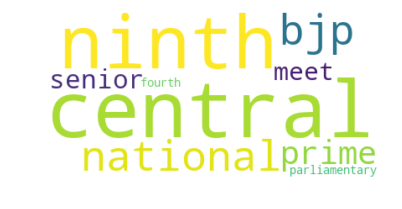

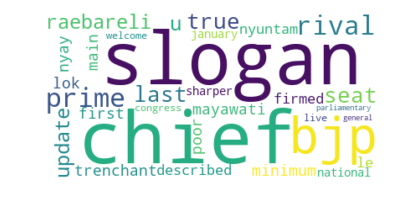

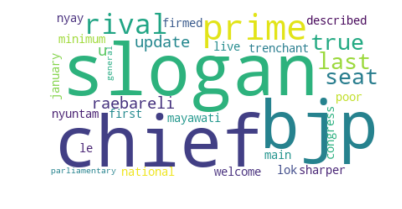

In [147]:
generate_adjectives_wordcloud(new_df)

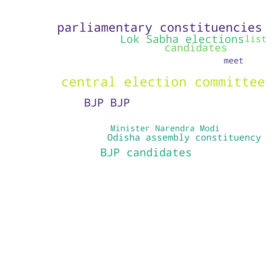

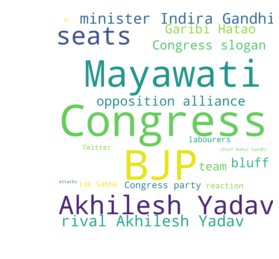

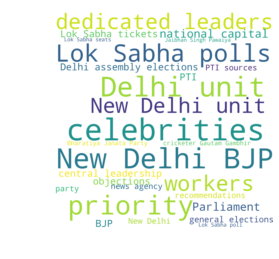

In [148]:
generate_centrality_wordcloud(new_df)

In [149]:
src_labels = ["Trusted Source: DD","Other Source 1: NDTV","Other Source 2: Times"]
generate_common_sentiment_plot(new_df,src_labels)

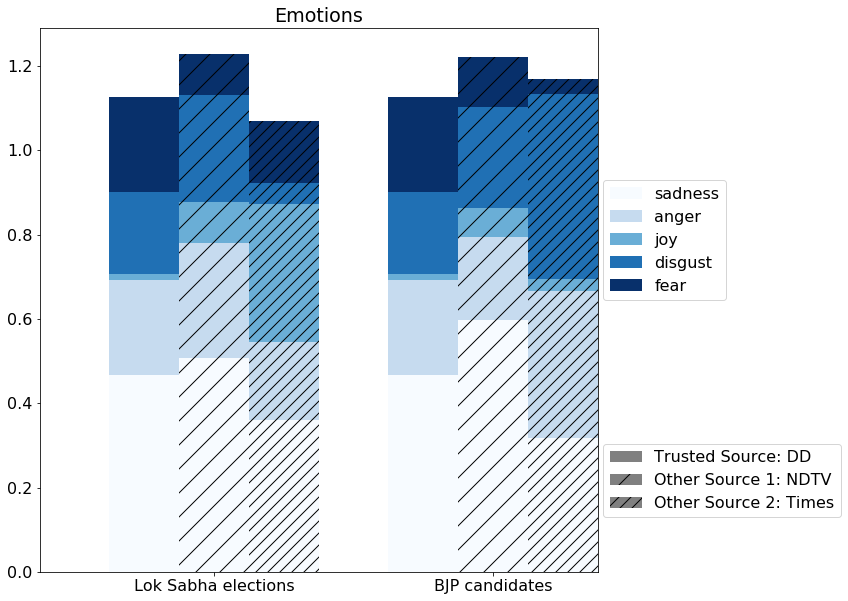

In [150]:
src_labels = ["Trusted Source: DD","Other Source 1: NDTV","Other Source 2: Times"]
generate_common_emotion_plot(new_df,src_labels)

In [152]:
generate_donut_charts(new_df)

In [160]:
generate_missing_sentiment_plot(new_df)

In [163]:
generate_missing_emotion_plot(new_df)